<a href="https://colab.research.google.com/github/FazilShah/Neural-Networks/blob/main/Neural_Network_without_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from testCases_v4a import *
import dnn_app_utils_v3 as dp

In [ ]:
def initialize_parametersz(L_dims):
  np.random.seed(1)
  parameters = {}
  L = len(L_dims)
  for l in range(1, L):
    parameters["W" + str(l)] = np.random.randn(L_dims[l], L_dims[l-1])/np.sqrt(L_dims[l-1])
    parameters["b" + str(l)] = np.zeros((L_dims[l], 1))
  
  return parameters

In [ ]:
def relu_backward(dA, cache):
  z = cache
  dz = np.array(dA, copy=True)
  dz[z<=0] = 0
  return dz

In [ ]:
def sigmoid_backward(dA, cache):
  z = cache
  s = 1/(1+ np.exp(-z))
  dz = dA*s*(1-s)
  return dz

In [ ]:
def sigmoid(z):
  A  = 1/(1+np.exp(-z))
  cache = z
  return A, cache


In [ ]:
def relu(z):
  A = np.maximum(0, z)
  cache = z
  return A, cache

In [ ]:
def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache



In [ ]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.2797765635793423


In [ ]:
def compute_cost(AL, Y):

  m = Y.shape[1]

  logprobs = np.multiply(np.log(AL), Y) + np.multiply(np.log(1-AL), (1-Y))
  cost = -np.sum(logprobs)/m

  cost = np.squeeze(cost)
  assert(cost.shape == ())


  return cost


In [ ]:
def linear_activation_forward(A_prev, w, b, activation):

  if activation == 'sigmoid':
    Z, linear_cache = linear_forward(A_prev, w, b)
    A, activation_cache = sigmoid(Z)
  elif activation == 'relu':
    Z, linear_cache = linear_forward(A_prev, w, b)
    A, activation_cache = relu(Z)
  cache = (linear_cache, activation_cache)
  return A, cache

In [ ]:
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters)//2
  for l in range(1, L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = 'relu')
    caches.append(cache)
  AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = 'sigmoid')
  caches.append(cache)
  return AL, caches



In [ ]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = (np.dot(dZ, A_prev.T))/m
  db = np.sum(dZ, axis = 1, keepdims = True)/m
  dA_prev = np.dot(W.T, dZ)
  return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  
  if activation == 'sigmoid':
    dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  elif activation == 'relu':
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db



In [ ]:
def L_model_backward(AL,Y, caches):
  L = len(caches)
  m = AL.shape[1]
  grads = {}
  Y = Y.reshape(AL.shape)
  dAL = -(np.divide(Y, AL) - np.divide((1-Y), (1-AL)))
  
  current_cache = caches[L-1]
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation='sigmoid')
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    
    dA_temp, dw_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = 'relu')
    grads["dA" + str(l)] = dA_temp
    grads["dW" + str(l+1)] = dw_temp
    grads["db" + str(l+1)] = db_temp
  
  return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters)//2
  for l in range(L):
    parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
  
  return parameters

In [ ]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Now, We Will apply the above Neural Network on the dataset

In [ ]:
#loading the data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

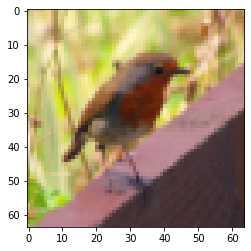

In [ ]:
#Checking the picture from the above dataset
plt.imshow(train_x_orig[10])

#The above picture turned out to be a flower. We are trying classification with cat vs non cats

In [ ]:
#Let's see how many examples we have

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of test examples: " + str(m_test))

Number of training examples: 209
Number of test examples: 50


In [ ]:
#Reshape the training and test examples

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [ ]:
layer_dims = [12288, 20, 7, 5, 1]

In [ ]:
def L_Layer_Model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 300, print_cost = False):
  np.random.seed(1)

  costs = [] 

  parameters = initialize_parametersz(layer_dims)

  for i in range(0, num_iterations):

    AL, caches = L_model_forward(X, parameters)

    cost = compute_cost(AL,Y)    

    grads = L_model_backward(AL,Y,caches)

    parameters = update_parameters(parameters, grads, learning_rate)

    if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)

  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  
  
  return parameters




Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


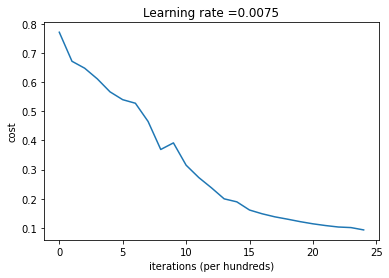

In [ ]:
parameters = L_Layer_Model(train_x, train_y, layer_dims, num_iterations=2500, print_cost=True)

In [ ]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
